In [30]:
import pandas as pd
import numpy as np
import re

from joblib import parallel_backend, dump, load

from nltk.corpus import stopwords, wordnet
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, make_scorer, log_loss

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, \
            GridSearchCV

from imblearn.over_sampling import SMOTENC, SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from code.cleaner import preprocess
from code.viz import word_plot

sns.set()

In [2]:
sentiments = pd.read_csv(
    './data/judge-1377884607_tweet_product_company.csv',
    encoding='ISO-8859-1')
sentiments.tail()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product
9092,Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...,NaN,No emotion toward brand or product


In [3]:
# sentiments['product'] = sentiments['emotion_in_tweet_is_directed_at']
# sentiments['sentiment'] = sentiments['is_there_an_emotion_directed_at_a_brand_or_product']

sentiments.rename(columns={
    'emotion_in_tweet_is_directed_at':'product',
    'is_there_an_emotion_directed_at_a_brand_or_product':'sentiment'
},inplace=True)

In [4]:
sentiments.dropna(subset=['tweet_text'],inplace=True)

In [5]:
sentiments['sentiment'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

Here, we'll split off the sentiments listed as "I can't
tell" into their own dataframe and drop them from the
original.

In [6]:
reclassify = sentiments[sentiments['sentiment'] == "I can't tell"]
sentiments = sentiments[sentiments['sentiment'] != "I can't tell"]

In [7]:
sw = stopwords.words('english')
specific_words = ['@mention','link','sxsw','#sxsw','@sxsw']
# ^^ these are the original extended stop words from initial data
# discovery and knowledge 
discovered_words = [
    'google','iphone', 'ipad', 'android', 'app',
    'apple', 'rt', 'quot', 'store', 'new', 'austin'
    ]
specific_words.extend(discovered_words)
sw.extend(specific_words)

In [8]:
preprocess(sentiments.head()['tweet_text'],sw)

['@wesley g hr tweet #rise dead need upgrade plugin station',
 '@jessedee know @fludapp awesome likely appreciate design also give free t',
 '@swonderlin wait #ipad also sale',
 'hope year festival crashy year',
 '@sxtxstate great stuff fri marissa mayer tim reilly tech book conference amp matt mullenweg wordpress']

In [9]:
sentiments['tokenized'], sentiments['tokens'] = \
    preprocess(sentiments['tweet_text'],sw=sw,ret_tokens=True)

In [10]:
X = sentiments[['tokenized','tokens']]
y = sentiments['sentiment']

X_train, X_test, y_train, y_test = \
    train_test_split(X,y,
        test_size=0.2,
        stratify=y,random_state=13)

train = X_train.merge(
    y_train,left_index=True,right_index=True
    )
test = X_test.merge(
    y_test,left_index=True,right_index=True
    )

Index(['#ipad', 'get', 'launch', 'line'], dtype='object')


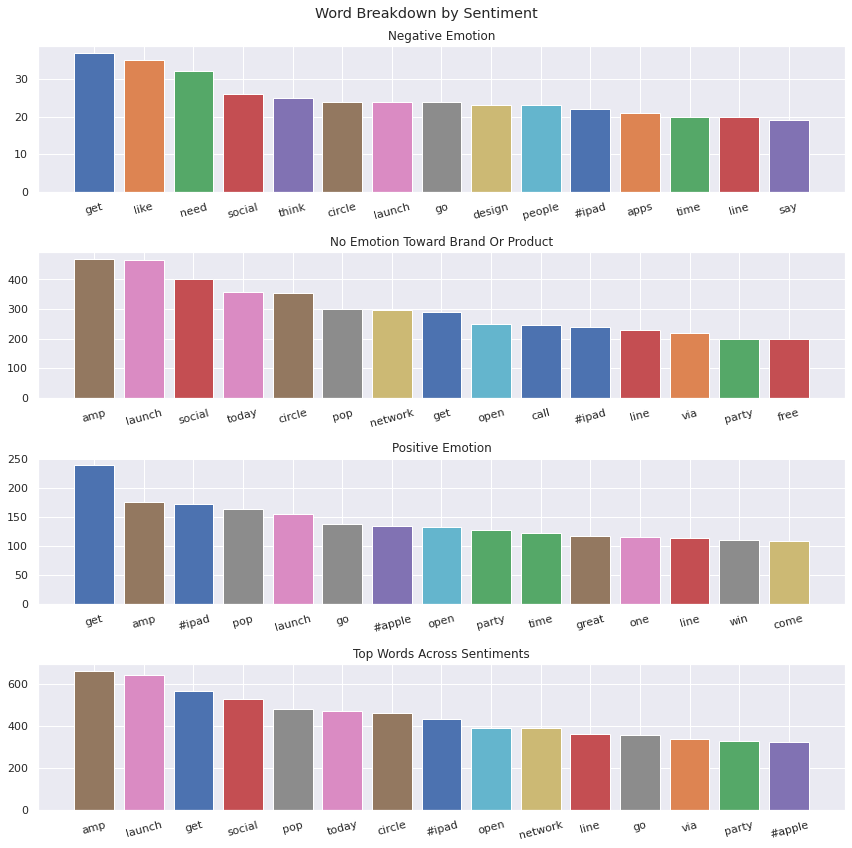

In [11]:
# train = X_train.merge(
#     y_train,left_index=True,right_index=True
#     )
freq_words = word_plot(train,'sentiment','tokens',
    n_words=15)
print(freq_words[1])

Index(['amp', 'go', 'social'], dtype='object')


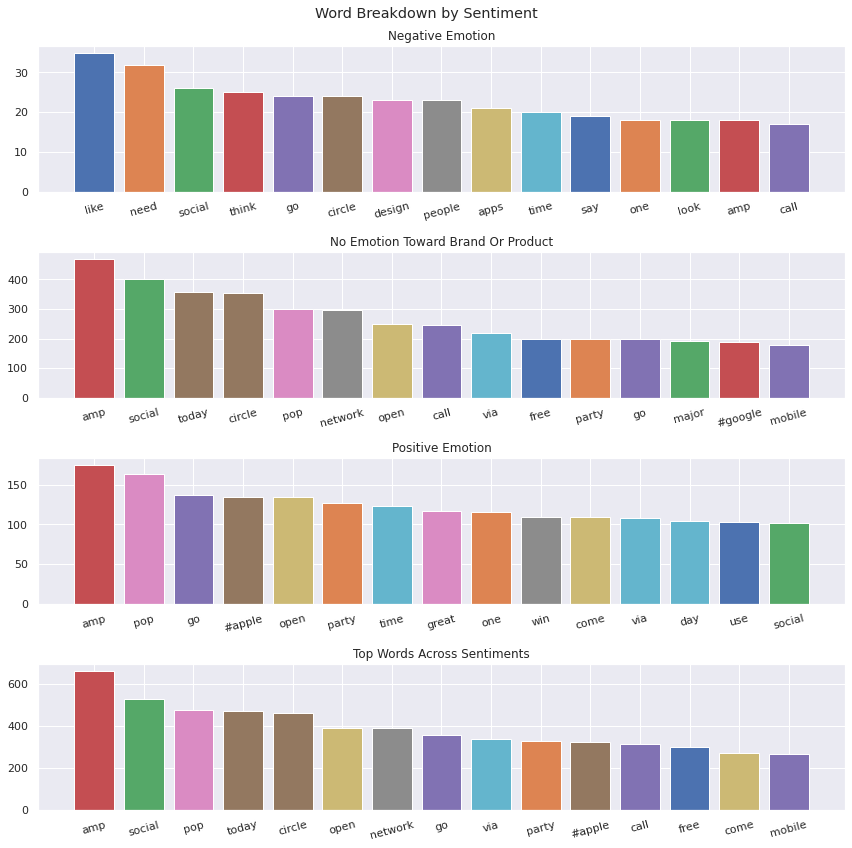

In [12]:
sw.extend(freq_words[1])
train['tokenized'], train['tokens'] = preprocess(train['tokenized'],sw,ret_tokens=True)
freq_words = word_plot(train,'sentiment','tokens',
    n_words=15)
print(freq_words[1])

Index(['today'], dtype='object')


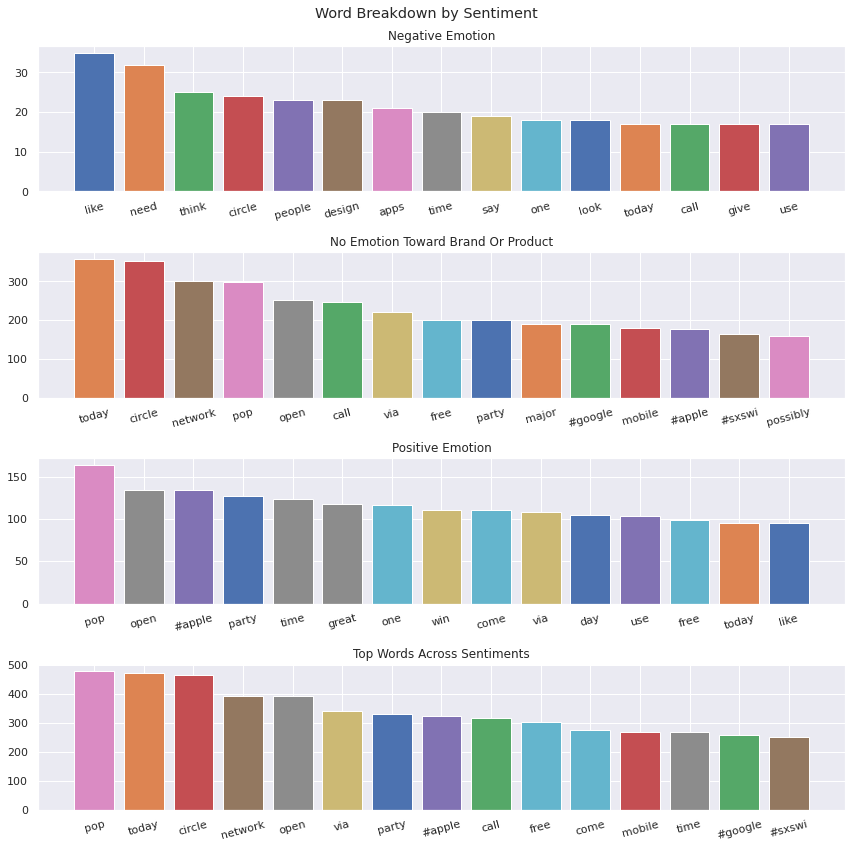

In [13]:
sw.extend(freq_words[1])
train['tokenized'], train['tokens'] = preprocess(train['tokenized'],sw,ret_tokens=True)
freq_words = word_plot(train,'sentiment','tokens',
    n_words=15)
print(freq_words[1])

Index(['pop'], dtype='object')


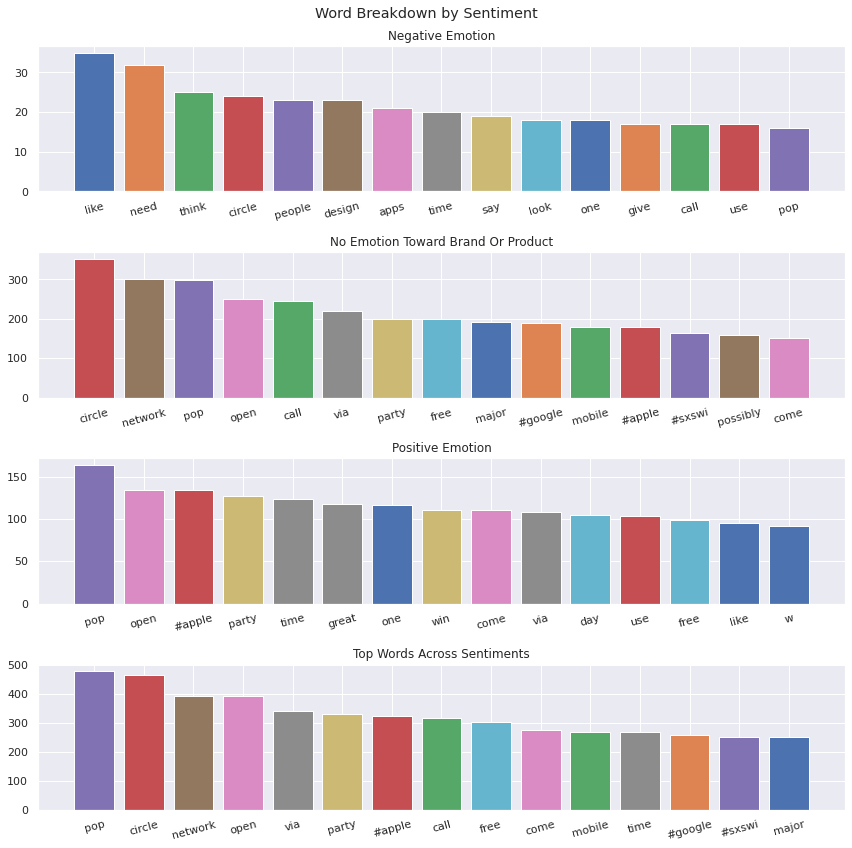

In [14]:
sw.extend(freq_words[1])
train['tokenized'], train['tokens'] = preprocess(train['tokenized'],sw,ret_tokens=True)
freq_words = word_plot(train,'sentiment','tokens',
    n_words=15)
print(freq_words[1])

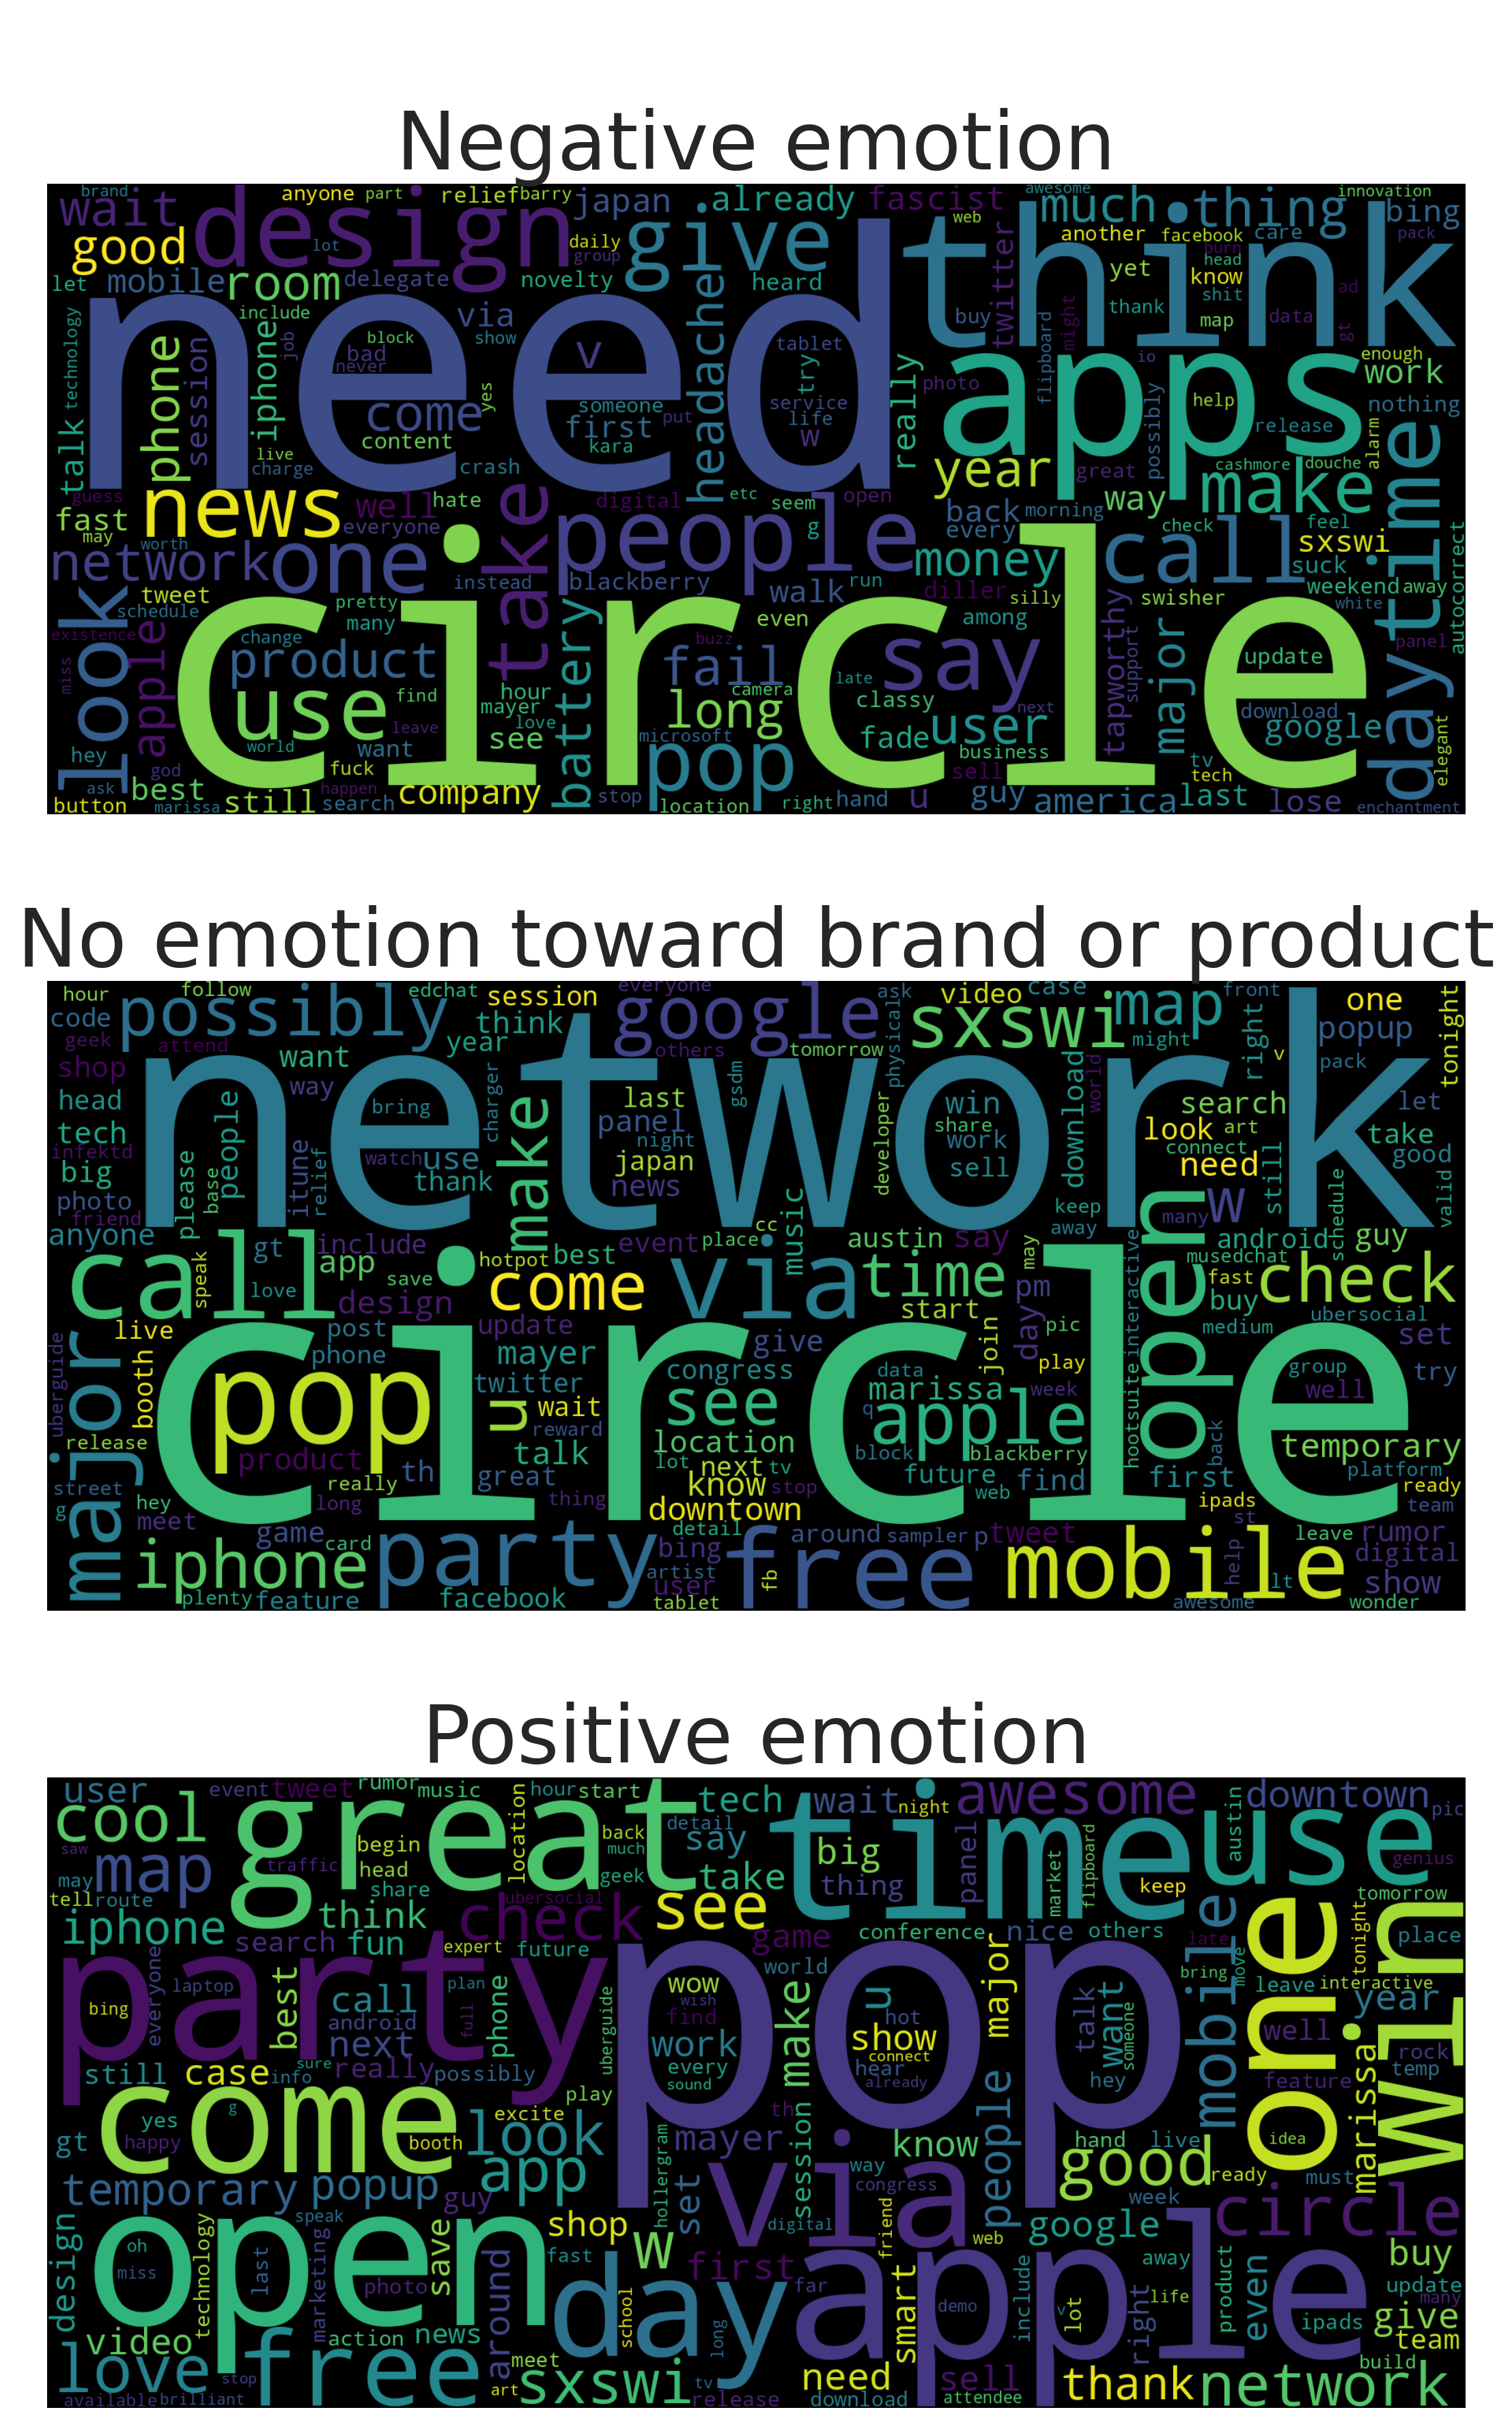

In [15]:
fig, ax = plt.subplots(3,1,figsize=(10,14),dpi=250)
for i, emo in enumerate(train['sentiment'].unique()):
    tmp_ = train[train['sentiment'] == emo]
    ax_ = ax[i]
    wordcloud = WordCloud(
        collocations=False, width=1800,height=800
        ).generate(' '.join(tmp_['tokenized']))
    ax_.set_title(f"\n{emo}",fontsize=34)
    ax_.imshow(wordcloud, interpolation='bilinear')
    ax_.axis('off')
plt.tight_layout(pad=0)

We can see that the word "Circle" appears at a high
volume in every category. Looking through the data,
this is because Google launched a social network called
"Circle" that was a large topic during the SXSW event
that was taking place during the time of our dataset's
collection.

In [16]:
sw.extend(['circle'])
train['tokenized'],train['tokens'] = \
    preprocess(train['tokenized'],sw,ret_tokens=True)

In [17]:
tfidf = TfidfVectorizer(ngram_range=[1,3],max_df=0.4,min_df=20)
train_tfidf = tfidf.fit_transform(train['tokenized'])
# X = tfidf.fit_transform(sentiment_tokens)
train_vec = pd.DataFrame(train_tfidf.toarray(),columns=tfidf.get_feature_names())

In [18]:
test_tfidf = tfidf.transform(test['tokenized'])
test_vec = pd.DataFrame(test_tfidf.toarray(),columns=tfidf.get_feature_names())

In [19]:
rfc = RandomForestClassifier(n_jobs=-2,random_state=13)
knc = KNeighborsClassifier(n_jobs=-2)
mnb = MultinomialNB()
svc = SVC(random_state=13)

scoring = 'f1_weighted'

rfc_grid = {
    'max_depth':[15,20,25,30],
    'min_samples_split':[10,15,20]
}
knc_grid = {
    'n_neighbors':[3,5,7,9]
}
mnb_grid = {
}
svc_grid = {
    'kernel':['poly','rbf'],
    'degree':[3,4]
}

rfc = GridSearchCV(
    rfc,rfc_grid,
    scoring=scoring
)
knc = GridSearchCV(
    knc,knc_grid,
    scoring=scoring
)
mnb = GridSearchCV(
    mnb,mnb_grid,
    scoring=scoring
)
svc = GridSearchCV(
    svc,svc_grid,
    scoring=scoring
)

classifiers = [rfc,knc,mnb,svc]

majority_length = len(train[train['sentiment'] == 'No emotion toward brand or product'])
sub_majority_length = len(train[train['sentiment'] == 'Positive emotion'])

if sub_majority_length*2 > majority_length:
    scale_size = sub_majority_length*2
else:
    scale_size = majority_length

sm_dict = {
    "No emotion toward brand or product"    : scale_size,
    "Positive emotion"                      : scale_size*0.5,
    "Negative emotion"                      : scale_size*0.5
}

o = SMOTE(random_state=13)
# o_grid = {
#     'sampling_strategy':['minority','auto',sm_dict]
# }
o_grid = ['minority','auto',sm_dict]

# o = GridSearchCV(
#     o,o_grid,
#     scoring=scoring
# )
pipe = imbPipeline(
    steps=[
        ('o',o),
        ('search',DummyClassifier())
    ]
)

grid = [
    {'o':['passthrough'],
    'search':[*classifiers]},
    {'o':[o],
    'o__sampling_strategy':o_grid,
    'search':[*classifiers]}
]

In [20]:
# o.fit(train_vec)

In [21]:
SMOTE?

Init signature:
SMOTE(
    *,
    sampling_strategy='auto',
    random_state=None,
    k_neighbors=5,
    n_jobs=None,
)
Docstring:     
Class to perform over-sampling using SMOTE.

This object is an implementation of SMOTE - Synthetic Minority
Over-sampling Technique as presented in [1]_.

Read more in the :ref:`User Guide <smote_adasyn>`.

Parameters
----------
sampling_strategy : float, str, dict or callable, default='auto'
    Sampling information to resample the data set.

    - When ``float``, it corresponds to the desired ratio of the number of
      samples in the minority class over the number of samples in the
      majority class after resampling. Therefore, the ratio is expressed as
      :math:`\alpha_{os} = N_{rm} / N_{M}` where :math:`N_{rm}` is the
      number of samples in the minority class after resampling and
      :math:`N_{M}` is the number of samples in the majority class.

        .. warning::
           ``float`` is only available for **binary** classification

In [22]:
gs = GridSearchCV(
    pipe,grid,scoring=scoring,
    verbose=3
)
# gs.fit(train_vec,train['sentiment'])

In [23]:
with parallel_backend('threading',n_jobs=-2):
    gs.fit(train_vec,train['sentiment'])

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] o=passthrough, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20]},
             scoring='f1_weighted') 
[CV] o=passthrough, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20]},
             scoring='f1_weighted') 
[CV] o=passthrough, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20]},
             scoring='f1_weighted') 
[CV] o=passthrough, search=GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-2),
             param_grid={'n_neighbors': [3, 5, 7, 9]}, scoring='f1_weighted') 
[CV] o=pa

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 23 concurrent workers.


[CV]  o=passthrough, search=GridSearchCV(estimator=MultinomialNB(), param_grid={}, scoring='f1_weighted'), score=0.593, total=   5.1s
[CV] o=SMOTE(random_state=13), o__sampling_strategy=minority, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20]},
             scoring='f1_weighted') 
[CV]  o=passthrough, search=GridSearchCV(estimator=MultinomialNB(), param_grid={}, scoring='f1_weighted'), score=0.619, total=   5.1s
[CV] o=SMOTE(random_state=13), o__sampling_strategy=minority, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20]},
             scoring='f1_weighted') 
[CV]  o=passthrough, search=GridSearchCV(estimator=MultinomialNB(), param_grid={}, scoring='f1_weighted'), score=0.589, total=   5.4s
[C

/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (4000) in class No emotion toward brand or product will be larger than the number of samples in the majority class (class #No emotion toward brand or product -> 3448)
  warnings.warn(


[CV]  o=SMOTE(random_state=13), o__sampling_strategy=auto, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20]},
             scoring='f1_weighted'), score=0.572, total= 8.2min
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4000, 'Positive emotion': 2000, 'Negative emotion': 2000}, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20]},
             scoring='f1_weighted') 


/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (4000) in class No emotion toward brand or product will be larger than the number of samples in the majority class (class #No emotion toward brand or product -> 3448)
  warnings.warn(


[CV]  o=SMOTE(random_state=13), o__sampling_strategy=auto, search=GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-2),
             param_grid={'n_neighbors': [3, 5, 7, 9]}, scoring='f1_weighted'), score=0.468, total= 4.4min
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4000, 'Positive emotion': 2000, 'Negative emotion': 2000}, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20]},
             scoring='f1_weighted') 


/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (4000) in class No emotion toward brand or product will be larger than the number of samples in the majority class (class #No emotion toward brand or product -> 3448)
  warnings.warn(


[CV]  o=SMOTE(random_state=13), o__sampling_strategy=auto, search=GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-2),
             param_grid={'n_neighbors': [3, 5, 7, 9]}, scoring='f1_weighted'), score=0.487, total= 4.6min
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4000, 'Positive emotion': 2000, 'Negative emotion': 2000}, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20]},
             scoring='f1_weighted') 


/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (4000) in class No emotion toward brand or product will be larger than the number of samples in the majority class (class #No emotion toward brand or product -> 3448)
  warnings.warn(


[CV]  o=passthrough, search=GridSearchCV(estimator=SVC(random_state=13),
             param_grid={'degree': [3, 4], 'kernel': ['poly', 'rbf']},
             scoring='f1_weighted'), score=0.642, total=12.4min
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4000, 'Positive emotion': 2000, 'Negative emotion': 2000}, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20]},
             scoring='f1_weighted') 


/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (4000) in class No emotion toward brand or product will be larger than the number of samples in the majority class (class #No emotion toward brand or product -> 3448)
  warnings.warn(


[CV]  o=passthrough, search=GridSearchCV(estimator=SVC(random_state=13),
             param_grid={'degree': [3, 4], 'kernel': ['poly', 'rbf']},
             scoring='f1_weighted'), score=0.618, total=12.5min
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4000, 'Positive emotion': 2000, 'Negative emotion': 2000}, search=GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-2),
             param_grid={'n_neighbors': [3, 5, 7, 9]}, scoring='f1_weighted') 


/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (4000) in class No emotion toward brand or product will be larger than the number of samples in the majority class (class #No emotion toward brand or product -> 3448)
  warnings.warn(


[CV]  o=passthrough, search=GridSearchCV(estimator=SVC(random_state=13),
             param_grid={'degree': [3, 4], 'kernel': ['poly', 'rbf']},
             scoring='f1_weighted'), score=0.620, total=12.7min
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4000, 'Positive emotion': 2000, 'Negative emotion': 2000}, search=GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-2),
             param_grid={'n_neighbors': [3, 5, 7, 9]}, scoring='f1_weighted') 


/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (4000) in class No emotion toward brand or product will be larger than the number of samples in the majority class (class #No emotion toward brand or product -> 3448)
  warnings.warn(


[CV]  o=SMOTE(random_state=13), o__sampling_strategy=auto, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20]},
             scoring='f1_weighted'), score=0.585, total= 8.0min
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4000, 'Positive emotion': 2000, 'Negative emotion': 2000}, search=GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-2),
             param_grid={'n_neighbors': [3, 5, 7, 9]}, scoring='f1_weighted') 


/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (4000) in class No emotion toward brand or product will be larger than the number of samples in the majority class (class #No emotion toward brand or product -> 3448)
  warnings.warn(


[CV]  o=passthrough, search=GridSearchCV(estimator=SVC(random_state=13),
             param_grid={'degree': [3, 4], 'kernel': ['poly', 'rbf']},
             scoring='f1_weighted'), score=0.636, total=13.0min
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4000, 'Positive emotion': 2000, 'Negative emotion': 2000}, search=GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-2),
             param_grid={'n_neighbors': [3, 5, 7, 9]}, scoring='f1_weighted') 


/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (4000) in class No emotion toward brand or product will be larger than the number of samples in the majority class (class #No emotion toward brand or product -> 3448)
  warnings.warn(


[CV]  o=SMOTE(random_state=13), o__sampling_strategy=auto, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20]},
             scoring='f1_weighted'), score=0.615, total= 8.0min
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4000, 'Positive emotion': 2000, 'Negative emotion': 2000}, search=GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-2),
             param_grid={'n_neighbors': [3, 5, 7, 9]}, scoring='f1_weighted') 


/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (4000) in class No emotion toward brand or product will be larger than the number of samples in the majority class (class #No emotion toward brand or product -> 3448)
  warnings.warn(


[CV]  o=passthrough, search=GridSearchCV(estimator=SVC(random_state=13),
             param_grid={'degree': [3, 4], 'kernel': ['poly', 'rbf']},
             scoring='f1_weighted'), score=0.631, total=13.2min
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4000, 'Positive emotion': 2000, 'Negative emotion': 2000}, search=GridSearchCV(estimator=MultinomialNB(), param_grid={}, scoring='f1_weighted') 


/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (4000) in class No emotion toward brand or product will be larger than the number of samples in the majority class (class #No emotion toward brand or product -> 3448)
  warnings.warn(


[CV]  o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4000, 'Positive emotion': 2000, 'Negative emotion': 2000}, search=GridSearchCV(estimator=MultinomialNB(), param_grid={}, scoring='f1_weighted'), score=0.593, total=  40.2s
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4000, 'Positive emotion': 2000, 'Negative emotion': 2000}, search=GridSearchCV(estimator=MultinomialNB(), param_grid={}, scoring='f1_weighted') 


/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (4000) in class No emotion toward brand or product will be larger than the number of samples in the majority class (class #No emotion toward brand or product -> 3448)
  warnings.warn(


[CV]  o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4000, 'Positive emotion': 2000, 'Negative emotion': 2000}, search=GridSearchCV(estimator=MultinomialNB(), param_grid={}, scoring='f1_weighted'), score=0.585, total=  39.5s
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4000, 'Positive emotion': 2000, 'Negative emotion': 2000}, search=GridSearchCV(estimator=MultinomialNB(), param_grid={}, scoring='f1_weighted') 


/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (4000) in class No emotion toward brand or product will be larger than the number of samples in the majority class (class #No emotion toward brand or product -> 3448)
  warnings.warn(


[CV]  o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4000, 'Positive emotion': 2000, 'Negative emotion': 2000}, search=GridSearchCV(estimator=MultinomialNB(), param_grid={}, scoring='f1_weighted'), score=0.584, total=  38.1s
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4000, 'Positive emotion': 2000, 'Negative emotion': 2000}, search=GridSearchCV(estimator=MultinomialNB(), param_grid={}, scoring='f1_weighted') 


/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (4000) in class No emotion toward brand or product will be larger than the number of samples in the majority class (class #No emotion toward brand or product -> 3448)
  warnings.warn(


[CV]  o=SMOTE(random_state=13), o__sampling_strategy=auto, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20]},
             scoring='f1_weighted'), score=0.615, total= 8.8min
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4000, 'Positive emotion': 2000, 'Negative emotion': 2000}, search=GridSearchCV(estimator=MultinomialNB(), param_grid={}, scoring='f1_weighted') 


/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (4000) in class No emotion toward brand or product will be larger than the number of samples in the majority class (class #No emotion toward brand or product -> 3448)
  warnings.warn(


[CV]  o=SMOTE(random_state=13), o__sampling_strategy=auto, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20]},
             scoring='f1_weighted'), score=0.563, total= 8.8min
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4000, 'Positive emotion': 2000, 'Negative emotion': 2000}, search=GridSearchCV(estimator=SVC(random_state=13),
             param_grid={'degree': [3, 4], 'kernel': ['poly', 'rbf']},
             scoring='f1_weighted') 


/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (4000) in class No emotion toward brand or product will be larger than the number of samples in the majority class (class #No emotion toward brand or product -> 3448)
  warnings.warn(


[CV]  o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4000, 'Positive emotion': 2000, 'Negative emotion': 2000}, search=GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-2),
             param_grid={'n_neighbors': [3, 5, 7, 9]}, scoring='f1_weighted'), score=0.491, total= 3.4min
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4000, 'Positive emotion': 2000, 'Negative emotion': 2000}, search=GridSearchCV(estimator=SVC(random_state=13),
             param_grid={'degree': [3, 4], 'kernel': ['poly', 'rbf']},
             scoring='f1_weighted') 


/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (4000) in class No emotion toward brand or product will be larger than the number of samples in the majority class (class #No emotion toward brand or product -> 3448)
  warnings.warn(


[CV]  o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4000, 'Positive emotion': 2000, 'Negative emotion': 2000}, search=GridSearchCV(estimator=MultinomialNB(), param_grid={}, scoring='f1_weighted'), score=0.606, total=  42.0s
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4000, 'Positive emotion': 2000, 'Negative emotion': 2000}, search=GridSearchCV(estimator=SVC(random_state=13),
             param_grid={'degree': [3, 4], 'kernel': ['poly', 'rbf']},
             scoring='f1_weighted') 


/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (4000) in class No emotion toward brand or product will be larger than the number of samples in the majority class (class #No emotion toward brand or product -> 3448)
  warnings.warn(


[CV]  o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4000, 'Positive emotion': 2000, 'Negative emotion': 2000}, search=GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-2),
             param_grid={'n_neighbors': [3, 5, 7, 9]}, scoring='f1_weighted'), score=0.482, total= 3.4min
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4000, 'Positive emotion': 2000, 'Negative emotion': 2000}, search=GridSearchCV(estimator=SVC(random_state=13),
             param_grid={'degree': [3, 4], 'kernel': ['poly', 'rbf']},
             scoring='f1_weighted') 


/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (4000) in class No emotion toward brand or product will be larger than the number of samples in the majority class (class #No emotion toward brand or product -> 3448)
  warnings.warn(


[CV]  o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4000, 'Positive emotion': 2000, 'Negative emotion': 2000}, search=GridSearchCV(estimator=MultinomialNB(), param_grid={}, scoring='f1_weighted'), score=0.575, total=  41.5s
[CV] o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4000, 'Positive emotion': 2000, 'Negative emotion': 2000}, search=GridSearchCV(estimator=SVC(random_state=13),
             param_grid={'degree': [3, 4], 'kernel': ['poly', 'rbf']},
             scoring='f1_weighted') 


/home/jd/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (4000) in class No emotion toward brand or product will be larger than the number of samples in the majority class (class #No emotion toward brand or product -> 3448)
  warnings.warn(


[CV]  o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4000, 'Positive emotion': 2000, 'Negative emotion': 2000}, search=GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-2),
             param_grid={'n_neighbors': [3, 5, 7, 9]}, scoring='f1_weighted'), score=0.479, total= 3.5min
[CV]  o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4000, 'Positive emotion': 2000, 'Negative emotion': 2000}, search=GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-2),
             param_grid={'n_neighbors': [3, 5, 7, 9]}, scoring='f1_weighted'), score=0.481, total= 3.4min
[CV]  o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4000, 'Positive emotion': 2000, 'Negative emotion': 2000}, search=GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-2),
             param_grid={'n_neighbors': [3, 5, 7, 9]}, scoring='f1_weighted'), score=0.495, total= 3.6min
[CV]  o=SMOTE(random_state=13), o__sampl

[Parallel(n_jobs=-2)]: Done  62 out of  80 | elapsed: 17.9min remaining:  5.2min


[CV]  o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4000, 'Positive emotion': 2000, 'Negative emotion': 2000}, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20]},
             scoring='f1_weighted'), score=0.574, total= 6.4min
[CV]  o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4000, 'Positive emotion': 2000, 'Negative emotion': 2000}, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20]},
             scoring='f1_weighted'), score=0.583, total= 6.3min
[CV]  o=SMOTE(random_state=13), o__sampling_strategy={'No emotion toward brand or product': 4000, 'Positive emotion': 2000, 'Negative emotion': 2000}, search=GridSearchCV(e

[Parallel(n_jobs=-2)]: Done  80 out of  80 | elapsed: 42.4min finished


In [32]:
dump(gs.best_estimator_,'./data/best_estimator.pkl')

['./data/best_estimator.pkl']

In [24]:
gs.best_estimator_, \
gs.best_estimator_['search'], \
gs.best_estimator_['search'].best_params_, \
gs.best_score_

(Pipeline(steps=[('o', SMOTE(random_state=13)),
                 ('search',
                  GridSearchCV(estimator=SVC(random_state=13),
                               param_grid={'degree': [3, 4],
                                           'kernel': ['poly', 'rbf']},
                               scoring='f1_weighted'))]),
 GridSearchCV(estimator=SVC(random_state=13),
              param_grid={'degree': [3, 4], 'kernel': ['poly', 'rbf']},
              scoring='f1_weighted'),
 {'degree': 3, 'kernel': 'rbf'},
 0.6327653258543121)

In [25]:
best_top   = gs.best_estimator_.steps[0][1]
best_inner = gs.best_estimator_['search'].best_estimator_

In [26]:
best_model = imbPipeline(
    steps=[
        ('scaler',best_top),
        ('model',best_inner)
    ]
)

In [27]:
best_model.fit(train_vec,train['sentiment'])

Pipeline(steps=[('scaler', SMOTE(random_state=13)),
                ('model', SVC(random_state=13))])

In [28]:
y_pred = best_model.predict(train_vec)
train['sentiment'].value_counts(), \
f1_score(y_pred,train['sentiment'],average=None)

(No emotion toward brand or product    4310
 Positive emotion                      2382
 Negative emotion                       456
 Name: sentiment, dtype: int64,
 array([0.79890311, 0.90939044, 0.8579932 ]))

In [31]:
test_pred = best_model.predict(test_vec)
test['sentiment'].value_counts(), \
f1_score(test_pred,test['sentiment'],average=None)

(No emotion toward brand or product    1078
 Positive emotion                       596
 Negative emotion                       114
 Name: sentiment, dtype: int64,
 0.6632894504596333)

In [33]:
best_testimator = load('./data/best_estimator.pkl')

In [35]:
f1_score(
    best_testimator.predict(train_vec),
    train['sentiment'],
    average=None
)